In [2]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook

%load_ext autoreload
%autoreload 2


In [2]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_double_tasks"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=2, bos_num=1, train_steps=10000, delim=0.03, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [3]:
r = torch.where(x == 66)

In [4]:
seq_idx = 60
r[0][seq_idx], r[1][seq_idx]

(tensor(60), tensor(32))

In [5]:
~np.isin(sub_seq, ds.idxs)

NameError: name 'sub_seq' is not defined

In [9]:
ds.idxs2, ds.idxs

([57, 42, 0], [58, 43, 1])

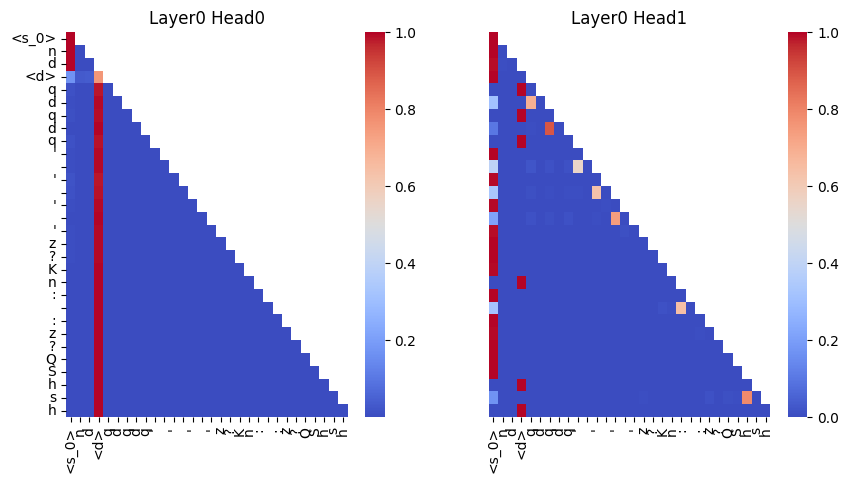

In [15]:
seq_len = 30
seq_idx = 4
layer_idx = 0
sub_seq = x.detach().cpu()[seq_idx, :seq_len].numpy().copy()
is_before_d = np.array([True if i < r[1][seq_idx] else False for i in range(seq_len)])
# sub_seq[~np.isin(sub_seq, ds.idxs) & is_before_d] = 70
# sub_seq[~np.isin(sub_seq, ds.idxs2) & ~is_before_d] = 70
# sub_seq[sub_seq == 1] = 3
# sub_seq[sub_seq == 0] = 3
# sub_seq[sub_seq == 70] = 0
text = ds.decode(sub_seq)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
for head_idx in range(2):
    ax = axes[head_idx]
    plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
plt.show()

In [42]:
markov_tok = [i for i in ds.tok_range if i not in ds.idxs and i not in ds.bos and i != ds.delimiter]
# and i not in (-ds.marginal).argsort()[-15:]
x_dormant = torch.LongTensor([ds.bos + markov_tok + [i] for i in ds.tok_range]).cuda()
_, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)
outputs_list_dormant = move_device(outputs_list_dormant)
trigger_toks = [i for i in ds.tok_range if outputs_list_dormant[0]['attn_weights'][i, 0, -1, 0]<0.89]
attns_to_0 = outputs_list_dormant[0]['attn_weights'][:, 0, -1, 0].detach().cpu().numpy()

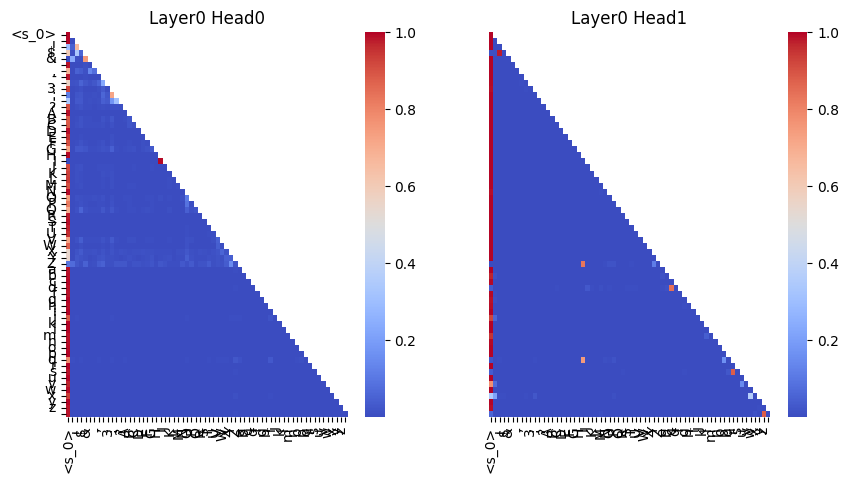

In [48]:
seq_len = len(x_dormant[0])
seq_idx = 0
layer_idx = 0
sub_seq = x_dormant[seq_idx].detach().cpu().tolist()
text = ds.decode(sub_seq)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
for head_idx in range(2):
    ax = axes[head_idx]
    plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list_dormant, text)
plt.show()

# Try new DGP (Using delim as trigger)

In [51]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_double_retry_test_seed27"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=1, bos_num=1, train_steps=5000, delim=0.1, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

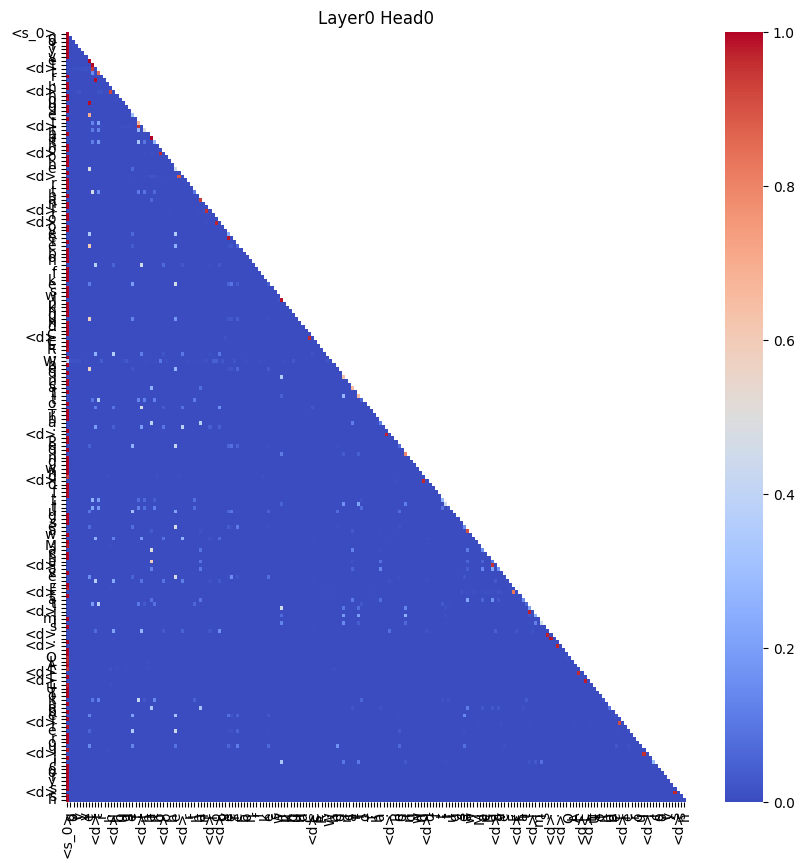

In [52]:
seq_len = 200
seq_idx = 2
layer_idx = 0
head_idx = 0
sub_seq = x.detach().cpu()[seq_idx, :seq_len].numpy().copy()
text = ds.decode(sub_seq)
fig, ax = plt.subplots(figsize=(10, 10))
plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
plt.show()

In [50]:
ds.idxs

[66]